In [16]:
import matplotlib.pyplot as plt

In [38]:
from sklearn import datasets
data = datasets.load_diabetes()

features_in_different_scale = True

if features_in_different_scale:
    data["data"][:, 0] = 100*data["data"][:, 0]
    data["data"][:, 1] = 10*data["data"][:, 1]
    data["data"][:, 2] = 0.01*data["data"][:, 2]
    data["data"][:, 3] = 10000*data["data"][:, 3]


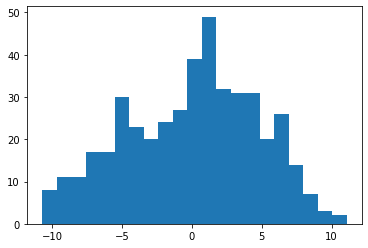

In [39]:
plt.hist(data["data"][:, 0], bins=21);

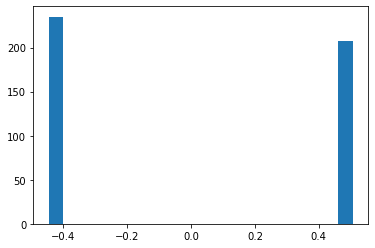

In [40]:
plt.hist(data["data"][:, 1], bins=21);

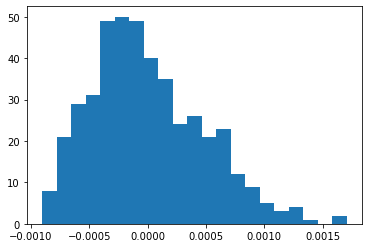

In [41]:
plt.hist(data["data"][:, 2], bins=21);

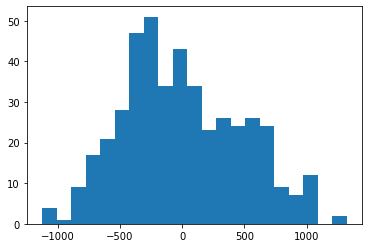

In [42]:
plt.hist(data["data"][:, 3], bins=21);

In [43]:
import torch

class QuantizeFeaturesStub(torch.nn.Module):
    def __init__(self, num_feats):
        super().__init__()
        self.num_feats = num_feats
        self.quants = torch.nn.ModuleList()
        for ifeat in range(self.num_feats):
            self.quants.append(torch.ao.quantization.QuantStub())

    def forward(self, x):
        return torch.cat([self.quants[ifeat](x[..., ifeat:ifeat+1]) for ifeat in range(self.num_feats)], axis=-1)
                 
# define a floating point model where some layers could be statically quantized
class M(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # QuantStub converts tensors from floating point to quantized
        
        self.quant = QuantizeFeaturesStub(10)
        self.lin1 = torch.nn.Linear(10, 128) #10 input features
        self.relu = torch.nn.ReLU()
        self.lin2 = torch.nn.Linear(128, 1) #1 regression output
        # DeQuantStub converts tensors from quantized to floating point
        self.dequant = torch.ao.quantization.DeQuantStub()

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.lin1(x)
        x = self.relu(x)
        x = self.lin2(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

In [44]:
model_fp32 = M()
optimizer = torch.optim.AdamW(model_fp32.parameters(), lr=0.005)
for epoch in range(2000):
    optimizer.zero_grad()
    out = model_fp32(torch.tensor(data["data"]).to(dtype=torch.float))
    loss = torch.nn.functional.mse_loss(out[:, 0], torch.tensor(data["target"]).to(torch.float))
    loss.backward()
    if epoch%100 == 0:
        print(epoch, loss.detach().cpu().item())
    optimizer.step()

0 40094.2265625
100 10841.3662109375
200 9539.228515625
300 7123.33984375
400 5970.48095703125
500 4988.68505859375
600 4103.28857421875
700 3669.591064453125
800 3488.14990234375
900 3393.9716796875
1000 3336.837646484375
1100 3277.173828125
1200 3228.7177734375
1300 3196.3447265625
1400 3174.423583984375
1500 3143.612548828125
1600 3135.796875
1700 3121.4189453125
1800 3098.261474609375
1900 3086.816650390625


In [45]:
import matplotlib.pyplot as plt

In [46]:
out = model_fp32(torch.tensor(data["data"]).to(torch.float)).detach().cpu().numpy()[:, 0]

(0.0, 400.0)

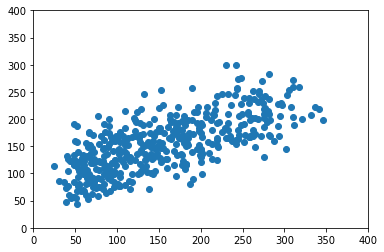

In [47]:
plt.scatter(data["target"], out)
plt.xlim(0,400)
plt.ylim(0,400)

In [48]:
# model must be set to eval mode for static quantization logic to work
model_fp32.eval()

# attach a global qconfig, which contains information about what kind
# of observers to attach. Use 'x86' for server inference and 'qnnpack'
# for mobile inference. Other quantization configurations such as selecting
# symmetric or asymmetric quantization and MinMax or L2Norm calibration techniques
# can be specified here.
# Note: the old 'fbgemm' is still available but 'x86' is the recommended default
# for server inference.
# model_fp32.qconfig = torch.ao.quantization.get_default_qconfig('fbgemm')

model_fp32.qconfig = torch.ao.quantization.get_default_qconfig("fbgemm", version=0)
# Fuse the activations to preceding layers, where applicable.
# This needs to be done manually depending on the model architecture.
# Common fusions include `conv + relu` and `conv + batchnorm + relu`
#model_fp32_fused = torch.ao.quantization.fuse_modules(model_fp32, [])

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.tensor(data["data"]).to(torch.float)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# run the model, relevant calculations will happen in int8
out_quantized = model_int8(input_fp32)[:, 0]

/cvmfs/sft.cern.ch/lcg/views/LCG_105/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/torch/ao/quantization/observer.py:214: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [49]:
model_fp32.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [50]:
input_fp32.shape

torch.Size([442, 10])

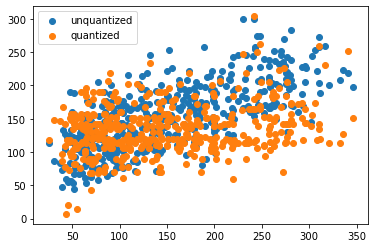

In [51]:
plt.scatter(data["target"], out, label="unquantized")
plt.scatter(data["target"], out_quantized, label="quantized")
plt.legend()
plt.show()

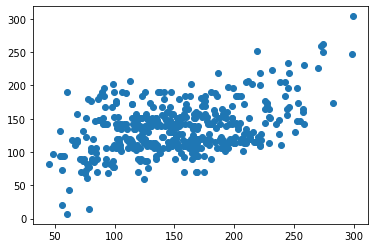

In [52]:
## quantized vs unquantized plot
plt.scatter(out, out_quantized)

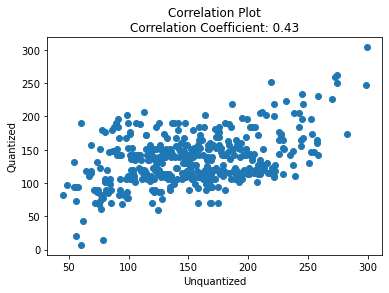

In [59]:
import numpy as np
# Calculate correlation coefficient
corr_coefficient = np.corrcoef(out, out_quantized)[0, 1]

# Plot the data and correlation coefficient
plt.scatter(out, out_quantized)
plt.title(f'Correlation Plot\nCorrelation Coefficient: {corr_coefficient:.2f}')
plt.xlabel('Unquantized')
plt.ylabel('Quantized')
# plt.grid(True)
plt.show()

In [ ]:
model_int8.quant

In [ ]:
x1 = model_int8.quant(input_fp32)
x1

In [ ]:
model_int8.lin1

In [ ]:
x2 = model_int8.lin1(x1)
x2

In [ ]:
x3 = model_int8.relu(x2)
x3

In [ ]:
model_int8.lin2

In [ ]:
x4 = model_int8.lin2(x3)
x4[:10]

In [ ]:
model_int8.dequant

In [ ]:
x5 = model_int8.dequant(x4)

In [ ]:
plt.scatter(data["target"], x5[:, 0])

In [ ]:
import torch
import torch.ao.quantization as quantization

# Define the global QConfig with custom settings
qconfig = quantization.QConfig(
    activation=quantization.MinMaxObserver.with_args(
        dtype=torch.quint8,  # Change to torch.qint8 if needed
        qscheme=torch.per_tensor_symmetric  # Change to torch.per_tensor_affine for asymmetric quantization
    ),
    weight=quantization.default_observer.with_args(
        dtype=torch.qint8  # You can change the data type here if needed
    )
)

model_fp32.qconfig = qconfig

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.tensor(data["data"]).to(torch.float)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# Quantize the input tensor to match the expected data type of the quantized model
# This ensures compatibility between the input tensor and the quantized model
quantizer = torch.ao.quantization.QuantStub()
input_int8 = quantizer(input_fp32)

# Run the quantized model
out_quantized = model_int8(input_int8)[:, 0]


In [ ]:
import torch
import torch.ao.quantization as quantization

# Define a custom observer for L2Norm calibration
class L2NormObserver(quantization.ObserverBase):
    def __init__(self, dtype=torch.quint8, averaging_constant=0.1):
        super(L2NormObserver, self).__init__(dtype=dtype)
        self.averaging_constant = averaging_constant
        self.num_activations = 1  # Track the number of activations observed
        self.sum = 0.0
        self.sum_square = 0.0

    def forward(self, x_orig):
        x = x_orig.detach()  # Ensure no gradient is backpropagated through this operation
        x = x.view(-1)  # Flatten the tensor to 1D
        self.num_activations += x.size(0)
        self.sum += x.sum().item()
        self.sum_square += (x ** 2).sum().item()

    def calculate_qparams(self):
        N = self.num_activations
        sum_val = self.sum
        sum_square_val = self.sum_square

        mean = sum_val / N
        var = sum_square_val / N - mean ** 2
        std = max(torch.tensor(var, dtype=torch.float32).sqrt(),
                  torch.tensor(self.averaging_constant, dtype=torch.float32))

        scale = (std / 127.0).clamp(1e-8, 1e-4)
        zero_point = torch.tensor(0, dtype=torch.int32)

        return scale, zero_point

# Define the global QConfig with custom settings including L2Norm calibration
qconfig = quantization.QConfig(
    activation=L2NormObserver.with_args(
        dtype=torch.quint8,  # Change to torch.qint8 if needed
        averaging_constant=0.1
    ),
    weight=quantization.default_observer.with_args(
        dtype=torch.qint8  # You can change the data type here if needed
    )
)

# Modify model_fp32.qconfig to use the global QConfig
model_fp32.qconfig = qconfig

# Prepare the model for static quantization. This inserts observers in
# the model that will observe activation tensors during calibration.
model_fp32_prepared = torch.ao.quantization.prepare(model_fp32)

input_fp32 = torch.tensor(data["data"]).to(torch.float)

# calibrate the prepared model to determine quantization parameters for activations
# in a real world setting, the calibration would be done with a representative dataset
model_fp32_prepared(input_fp32)

# Convert the observed model to a quantized model. This does several things:
# quantizes the weights, computes and stores the scale and bias value to be
# used with each activation tensor, and replaces key operators with quantized
# implementations.
model_int8 = torch.ao.quantization.convert(model_fp32_prepared)

# Quantize the input tensor to match the expected data type of the quantized model
# This ensures compatibility between the input tensor and the quantized model
quantizer = torch.ao.quantization.QuantStub()
input_int8 = quantizer(input_fp32)

# Run the quantized model
out_quantized = model_int8(input_int8)[:, 0]
